# Learn the Basics of ∇-Prox

This tutorial introduces you to a completed proximal optimization workflow implemented in ∇-Prox. For simplicities, we will use image deconvolution problem as an example to demonstrate the functionalities of ∇-Prox.

The goal of image deconvolution is to reconstruct the clear image $x$ from the blurred observation $y$ that is obtained by convolving $x$ by the point spread function (PSF) as 
$$
y = D(x, \text{PSF})
$$
where $D$ denotes convolution operation.

To reconstruct target image x from noise-contaminated measurements y, we minimize the sum of a data-fidelity $| D(x) - y |^2_2$ and regularizer term $r$ as,
$$
 \mathop{\mathrm{min}}_{x \in \mathbb{R}^n} ~ | D(x) - y |^2_2 + r (x ; \, \theta_r).
$$

We consider a hybrid regularizer including (1) an implict plug-and-play prior $g(x; \theta_r)$ paramterized by $\theta_r$ and (2) non-negative constraint of image. 
$$
r(x; \theta_r) = \lambda g(x; \theta_r) + I_{[0,\infty)},
$$


Note: In order to run the following tutorial, please install the requirements following the [Installtion tutorial]()

### Import libraries

In the begining, we import all the necessary libraries. 

In [1]:
!pip install dprox

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from dprox import *
from dprox.utils import *
from dprox.utils.examples import *

### Prepare Data

Then, let's generate some sample data to play with.

torch.Size([1, 3, 768, 1024]) torch.Size([1, 3, 768, 1024])


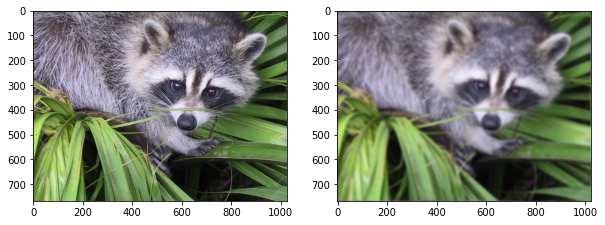

In [3]:
img = sample('face')
psf = point_spread_function(ksize=15, sigma=5)
y = blurring(img, psf) 
print(img.shape, y.shape)
imshow(img, y)

### Representing Optimization Problem in ∇-Prox

Recall our goal is to reconstruct the clear image given the blurred observation, by solving an optimziation problem as 
$$
 \mathop{\mathrm{min}}_{x \in \mathbb{R}^n} ~ | D(x) - y |^2_2 + \lambda g(x; \theta_r) + I_{[0,\infty)}.
$$

We can write down this problem in ∇-Prox with a very simple syntax that following the math. 

In [4]:
x = Variable()
data_term = sum_squares(conv(x, psf) - y)
prior_term = deep_prior(x, 'ffdnet_color')
reg_term = nonneg(x)
objective = data_term + prior_term + reg_term
p = Problem(objective)

### Basic Problem Solving

Solving the problem can be easily achieved by calling the `solve` method with the desired algorithms, e.g., ADMM in this case.

You could also try other algorithms, the compatible algorithms and reference performance are listed as below, 

| Key     | Method                                     | Expected PSNR |
|---------|--------------------------------------------|---------------|
| `admm`  | Alternative Direction Method of Multiplier | 31.94         |
| `hqs`   | Half Qudratic Splitting                    | 31.65         |
| `pc`    | Pockle Chamlle                             | 29.66         |
| `ladmm` | Linearized ADMM                            | 31.95         |

100%|██████████| 24/24 [00:01<00:00, 15.51it/s]


31.947329305648662


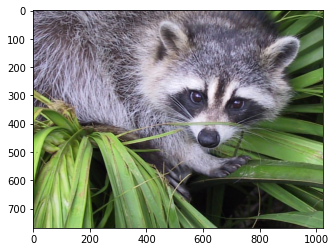

In [5]:
out = p.solve(method='admm', x0=y, pbar=True)
print(psnr(out, img)) 
imshow(out)

In many cases,  you need to manually tune the hyperparamters of the algorithm to achieve better performance. For example, let's consider a slightly harder noisy deconvolution problem as
$$
y = D(x, \text{PSF}) + \epsilon
$$
where $\epsilon$ denotes a small amount of Gaussian noise.

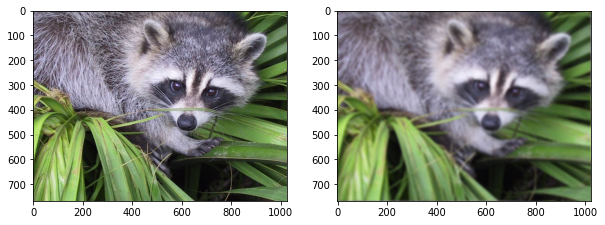

In [6]:
y = blurring(img, psf) + np.random.randn(*img.shape).astype('float32') * 5/255.0
imshow(img, y)

Again, let's solve the problem with ∇-Prox. We can see that default parameters diverge and fail to solve the problem.

100%|██████████| 24/24 [00:00<00:00, 26.12it/s]


-227.16076100007024


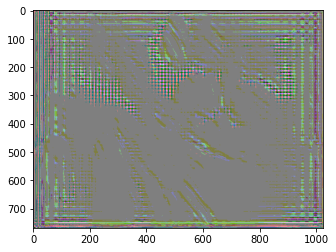

In [7]:
x = Variable()
data_term = sum_squares(conv(x, psf) - y)
prior_term = deep_prior(x, 'ffdnet_color')
reg_term = nonneg(x)
objective = data_term + prior_term + reg_term
p = Problem(objective)
out = p.solve(method='admm', x0=y, pbar=True)
print(psnr(out, img))
imshow(out)


To fix it, we have to manually tune the algorithm parameters. In ∇-Prox, this can be achieved by passing extra keyword arguments to `solve`, e.g., 

100%|██████████| 24/24 [00:00<00:00, 28.10it/s]


24.458249760033727


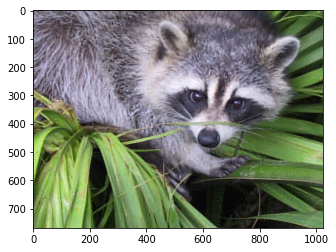

In [8]:
out = p.solve(method='admm', x0=y, rhos=0.004, lams=0.02, max_iter=24, pbar=True)
print(psnr(out, img))
imshow(out)

We should note that the manual parameter tuning is a tedious process. Different choices of paremters may affect the performance significantly. For example, by changing `rhos` to 0.1, the PSNR drops by 1.3 dB.

In [9]:
out = p.solve(method='admm', x0=y, rhos=0.1, lams=0.02, max_iter=24, pbar=True)
print(psnr(out, img))

100%|██████████| 24/24 [00:00<00:00, 27.94it/s]

23.125101413656598


In many cases, the optimal choice may vary for different inputs. Moreover, for real-world applications, we won't have ground-truth to evaluate the performance of different parameters for different inputs, which makes paramter tuning even harder.

To address it, ∇-Prox incorporates the automatic parameters scheduler that can be learned with reinforcement learning. Please refer to the [tutorial on automatic parameter scheduler]() for more details.